In [1]:
# Ref:https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append('pymodules')
# for dictionary method synonym finder using wordnet
#import nltk
#nltk.download('wordnet')
#nltk.download('omw-1.4')

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.models import Word2Vec
# making the plot look good ...
from adjustText import adjust_text
from sklearn.decomposition import PCA

from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
from tensorflow.keras.layers import Dropout

from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import metrics
from sklearn.model_selection import train_test_split, ParameterGrid

# this class read the raw input and tokenizes comprehensively for use with modeling
import pymodules.read_and_tokenize as contacts_utils

from timeit import default_timer as timer

/Users/bmukund/miniconda3/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
[nltk_data] Downloading package wordnet to /Users/bmukund/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/bmukund/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
filename = "data/Master-data_Q42021.xlsx"
prep_comments, df = contacts_utils.read_file(filename)

Read sheet 'Scrubbed_data' ...
Columns dropped: ['OVERALL_RATING', 'COMFORT_RATING', 'VISION_RATING', 'VALUE_FOR_MONEY', 'PROS', 'CONS', 'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE', 'PRODUCT_LINK', 'WEBSITE']
 Drop the Author column and replace it with gender of author ...
Consolidate all the comments into one column called COMMENT
Make ratings into integers
Tokenize data based on regex found from experimentation and common usage ...
Comments before tokenization at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
Comments after tokenization at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
Comments at index[0] before basic cleaning:
 Acucue 2 Contact Lenses I have used these lenses for a lon

In [3]:
# attach sentiment, seems
def find_sentiment(rating):
    choices = [0, 1, 2]
    conditions = [rating < 3, rating == 3, rating > 3]
    senti = np.select(conditions, choices)
    return senti

df['SENTIMENT'] = df['RATING'].apply(find_sentiment).astype('category')

In [4]:
require_bigrams = True
if require_bigrams:
    for i in range(len(prep_comments.tokens)):
        prep_comments.tokens[i] = prep_comments.tokens[i] + prep_comments.bigrams[i]

test_index = 0
print(f"Comments at index[{test_index}] after addition of bigrams:\n {prep_comments.tokens[test_index]}")
print(f"Comments at index[{-1}] after addition of bigrams:\n {prep_comments.tokens[-1]}")

Comments at index[0] after addition of bigrams:
 ['contact', 'used', 'time', 'service', 'com', 'great', 'work', 'great', 'needs', 'highly', 'recommend', 'contact-used', 'used-time', 'time-service', 'service-com', 'com-great', 'great-work', 'work-great', 'great-needs', 'needs-highly', 'highly-recommend']
Comments at index[-1] after addition of bigrams:
 ['buy', 'order', 'came', 'fast', 'without', 'issues', 'candy', 'nice', 'touch', 'buy-order', 'order-came', 'came-fast', 'fast-without', 'without-issues', 'issues-candy', 'candy-nice', 'nice-touch']


In [5]:
## Create Dictionary
#id2word = corpora.Dictionary(prep_comments.tokens)
## Create Corpus: Term Document Frequency
#corpus = [id2word.doc2bow(text) for text in prep_comments.tokens]
#print(corpus)

In [6]:
df['TOKENS'] = prep_comments.tokens

In [7]:
dfXY = df[['TOKENS', 'SENTIMENT']]

In [8]:
dfXY

,TOKENS,SENTIMENT
REVIEW_DATE,,
2021-11-01,"[contact, used, time, service, com, great, wor...",2
2021-12-02,"[clear, vision, tends, cloud, clear-vision, vi...",2
2021-12-01,"[comfort, hard, handle, flimsy, comfortable, e...",2
2021-11-16,"[easy, use, using, product, years, reliable, e...",2
2021-12-08,"[excellent, excellent, got, promised, discount...",2
...,...,...
2021-11-29,"[truly, best, price, fast, shipping, quick, ve...",2
2021-11-23,"[comfortable, vita, comfortable, wear, fact, c...",2
2021-12-27,"[comfortable, convenient, comfortable, conveni...",2


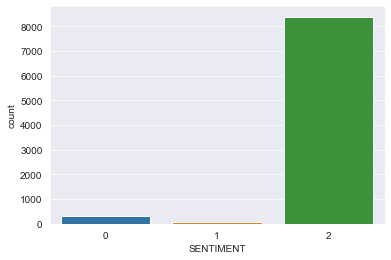

In [9]:
sns.countplot(dfXY.SENTIMENT)
plt.show()

### Highly imbalanced data
* Because of highly imbalanced data, we need to "balance" by using class weights while fitting any model

### take tokenized sentences and make it all integers using keras tokenizer on already tokenized data

In [10]:
# because embedding is independent of tokenization, we integerize our token based on keras tokenizer
num_expected_unique_words = 10000
keras_tokenizer = Tokenizer(num_expected_unique_words, split=",")
keras_tokenizer.fit_on_texts(dfXY['TOKENS'])

In [11]:
validation_reqd = True
X = dfXY.TOKENS
y = dfXY.SENTIMENT
df_trainX, df_trainy, df_testX, df_testy, df_validX, df_validy = contacts_utils.split_data(X, y, validation_reqd)

In [12]:
MAX_SEQ_LEN = 300
X_train=keras_tokenizer.texts_to_sequences(df_trainX) # this converts texts into some numeric sequences
X_train_pad=pad_sequences(X_train,maxlen=MAX_SEQ_LEN,padding='post') # this makes the length of all numeric sequences equal

X_test = keras_tokenizer.texts_to_sequences(df_testX)
X_test_pad = pad_sequences(X_test, maxlen = MAX_SEQ_LEN, padding = 'post')

if validation_reqd:
    X_val = keras_tokenizer.texts_to_sequences(df_validX)
    X_val_pad = pad_sequences(X_val, maxlen = MAX_SEQ_LEN, padding = 'post')
else:
    X_val = None
    X_val_pad = None

In [13]:
y_train = to_categorical(df_trainy.values,num_classes=3)
y_test = to_categorical(df_testy.values, num_classes=3)
if validation_reqd:
    y_val = to_categorical(df_validy.values, num_classes=3)
else:
    y_val = None

### Compute class weights based on training data to balance the dataset

In [14]:
from sklearn.utils.class_weight import compute_class_weight
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
sentiment_class_weights = dict(enumerate(class_weights))

{0: 7.460030165912519, 1: 34.34722222222222, 2: 0.3525051671299266}


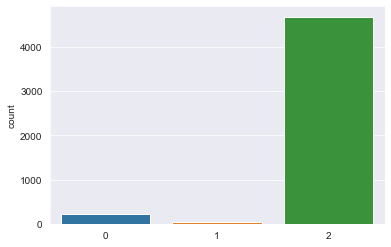

[ 221   48 4677]


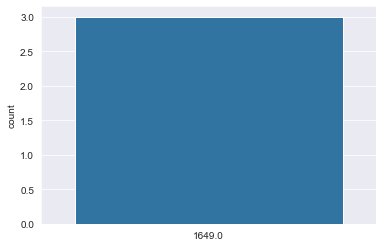

In [15]:
### Test if balancing has indeed taken place ...
print(sentiment_class_weights)
sns.countplot(y_integers)
plt.show()
print(np.bincount(y_integers))
balance_wts = np.array([val for k, val in sentiment_class_weights.items()])
bal = np.round(np.bincount(y_integers) * balance_wts)
sns.countplot(bal)
plt.show()

In [16]:
# train Gensim's Word2Vec model
gensim_model = Word2Vec(sentences=prep_comments.tokens,      # corpus
                        vector_size=100,            # embedding dimension
                        window=4,                   # words before and after to take into consideration
                        sg=1,                       # use skip-gram
                        negative=5,                 # number of negative examples for each positive one
                        alpha=0.025,                # initial learning rate
                        min_alpha=0.0001,           # minimum learning rate
                        epochs=10,                   # number of passes through the data
                        min_count=1,                # words that appear less than this are removed
                        workers=4,                  # we use 1 to ensure replicability
                        seed=92                     # for replicability
                        )

In [17]:
# extract the word embeddings from the model
word_vectors = gensim_model.wv
word_vectors.vectors.shape  # vocab_size x embeddings dimension

(29377, 100)

In [18]:
word_vectors_weights = gensim_model.wv.vectors
vocab_size, embedding_size = word_vectors_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 29377 - Embedding Dim: 100


In [19]:
# Some validation on the quality of the Word2Vec model
print(gensim_model.wv.most_similar('product', topn=3))
print(gensim_model.wv.most_similar('price', topn=3))
print(gensim_model.wv.most_similar('service', topn=3))
print(gensim_model.wv.most_similar('quality', topn=3))
print(gensim_model.wv.most_similar(positive=['comfort', 'fit'], negative=['dry'], topn=3))

def word2token(word):
    try:
        return gensim_model.wv.key_to_index[word]
    except KeyError:
        return 0

def token2word(token):
    return gensim_model.wv.index_to_key[token]

[('usual', 0.8906511068344116), ('complaints', 0.8849597573280334), ('product-issues', 0.8752360939979553)]
[('fee', 0.9062368869781494), ('receiving', 0.9008634686470032), ('reasonable', 0.8930147290229797)]
[('support', 0.9328551888465881), ('prompt', 0.9296995997428894), ('efficient', 0.9282112121582031)]
[('inexpensive', 0.9252446293830872), ('quality-contact', 0.9124814867973328), ('good-contact', 0.9109454154968262)]
[('comfort-fit', 0.8070130348205566), ('fit-comfort', 0.8048593401908875), ('great-comfort', 0.76300448179245)]


In [20]:
gensim_weight_matrix = np.zeros((num_expected_unique_words ,embedding_size))
gensim_weight_matrix.shape

(10000, 100)

### Test key to index for word vectors ...

In [21]:
word_vectors[word_vectors.key_to_index['dry']]

array([-0.7768502 ,  0.02300774,  0.26880482,  0.13142408, -0.53115755,
       -0.3739037 , -1.108656  , -0.6720339 ,  0.13040945,  0.532316  ,
        1.1707847 ,  0.12693594,  0.07948939, -0.05052609,  0.36457092,
        0.02171068, -0.25104254, -0.5830283 ,  0.41373563, -1.0604469 ,
        0.95258254, -0.5773645 ,  0.80656266,  0.5073695 , -0.2731006 ,
        0.26703632, -0.07272255, -0.1386635 , -0.7810804 ,  0.2614708 ,
        0.25357038,  0.48099288, -1.1897092 ,  0.235308  ,  1.0025603 ,
        0.13769008, -0.24867558, -0.27040824, -0.14294499, -0.46284276,
        0.29400438,  0.26128855, -0.33124903, -0.15286216,  0.08377958,
       -0.18434164,  0.5107179 ,  0.3370642 ,  0.2261591 ,  0.8912444 ,
        0.27115285,  0.00770176,  0.3386986 , -0.28057355, -0.7383073 ,
        0.1156505 ,  0.21219163, -0.44088534,  0.11250752, -0.09759232,
       -0.5503909 ,  0.5893717 , -0.08108548,  0.61314166,  0.4646472 ,
       -0.20553434,  0.07031621, -0.32457545,  0.14979306, -1.21

### map the index of the word (obtained by keras_tokenizer, which assigned interger values to words) to its weight matrix obtained from wrod embedding

In [22]:
for word, index in keras_tokenizer.word_index.items():
    if index < num_expected_unique_words: # why ? since index starts with zero
        try:
            word_index_in_embedding = word_vectors.key_to_index[word]
        except KeyError:
            gensim_weight_matrix[index] = np.zeros(embedding_size)
        else:
            gensim_weight_matrix[index] = word_vectors[word_index_in_embedding]

In [23]:
gensim_weight_matrix.shape

(10000, 100)

### RNN model

In [24]:
num_sentiments  = 3

In [25]:
#EarlyStopping and ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./sentiment_RNN_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [26]:
def create_RNN_model(num_sentiments, sentiment_class_weights, num_expected_unique_words, embedding_size, gensim_weight_matrix, trainX, trainy, validX, validy, testX, testy):
    def _create_RNN_model(param_dict):
        _epochs = param_dict['epochs']
        _batch_size = param_dict['batch_size']
        drop_out_factor = param_dict['drop_out_factor']
        lstm_nodes = param_dict['lstm_nodes']

        # fixed three layers ...
        model = Sequential()
        model.add(Embedding(input_dim = num_expected_unique_words,
                    output_dim = embedding_size,
                    input_length= trainX.shape[1],
                    weights = [gensim_weight_matrix],
                    trainable = False))

        model.add(Dropout(drop_out_factor[0]))
        model.add(Bidirectional(LSTM(lstm_nodes[0],return_sequences=True)))
        model.add(Dropout(drop_out_factor[1]))
        model.add(Bidirectional(LSTM(lstm_nodes[1],return_sequences=True)))
        model.add(Dropout(drop_out_factor[2]))
        model.add(Bidirectional(LSTM(lstm_nodes[2],return_sequences=False)))

        model.add(Dense(num_sentiments, activation = 'softmax'))

        model.compile(loss = 'categorical_crossentropy',
                      optimizer = 'adam',
                      metrics = 'accuracy')

        history = model.fit(trainX, trainy,
                            epochs = _epochs,
                            batch_size = _batch_size,
                            validation_data=(validX, validy),
                            verbose = 1,
                            callbacks= [es, mc],
                            class_weight = sentiment_class_weights,
                            workers=4,
                            use_multiprocessing=True)

        _, test_score = model.evaluate(testX,testy)
        y_pred_test_raw = model.predict(testX, workers=4, use_multiprocessing=True)
        y_test_pred = np.argmax(y_pred_test_raw, axis = 1)
        return test_score, param_dict, history, y_test_pred, model

    return _create_RNN_model

In [27]:
# parameters to be varied
batch_size = [120]
epochs = [2]
drop_out_factor = [[0.2, 0.2, 0.2]]
lstm_nodes = [[100, 200, 100]]

parameters = [{'epochs': epochs,
               'batch_size': batch_size,
               'drop_out_factor':drop_out_factor,
               'lstm_nodes':lstm_nodes
               }
              ]

# make a grid out of parameter choices ...
grid_params = ParameterGrid(parameters)
[print(x) for x in grid_params]

{'batch_size': 120, 'drop_out_factor': [0.2, 0.2, 0.2], 'epochs': 2, 'lstm_nodes': [100, 200, 100]}


[None]

In [28]:
# func that sets up the context .. i.e. what the pipeline does, what the data input is
RNN_model_func = create_RNN_model(num_sentiments, sentiment_class_weights, num_expected_unique_words,
                                  embedding_size, gensim_weight_matrix,
                                  X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test)

st_ = timer()
# run NN model in parallel and extract results (train_score, valid_score,parameter, history of fit) as a list
results = contacts_utils.run_parallel(RNN_model_func, num_cpus=4)(grid_params)

end_ = timer()

print(f"Time taken to finish best parameter search with RNN model: {(end_-st_)/60.0} mins.")

2022-08-02 21:41:13.439930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/2
42/42 [==============================] - ETA: 0s - loss: 1.0751 - accuracy: 0.6112
Epoch 1: val_accuracy improved from -inf to 0.62523, saving model to ./sentiment_RNN_model.h5
42/42 [==============================] - 156s 4s/step - loss: 1.0751 - accuracy: 0.6112 - val_loss: 1.1230 - val_accuracy: 0.6252
Epoch 2/2
42/42 [==============================] - ETA: 0s - loss: 1.0386 - accuracy: 0.6474
Epoch 2: val_accuracy improved from 0.62523 to 0.76349, saving model to ./sentiment_RNN_model.h5
69/69 [==============================] - 25s 327ms/step


INFO:tensorflow:Assets written to: ram://d11bf306-ea01-4667-bacb-90300ffc4782/assets


INFO:tensorflow:Assets written to: ram://d11bf306-ea01-4667-bacb-90300ffc4782/assets
2022-08-02 21:47:26.278018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Time taken to finish best parameter search with RNN model: 6.432630306716667 mins.


In [29]:
# find the best parameters based on validation score
# results => test_score, param_dict, history, y_test_pred, model
best_test_score = results[0][0]
best_params = results[0][1]
history_data = results[0][2]
y_test_prediction_data = results[0][3]
best_model = results[0][4]
for i in range(1, len(results)):
    tscore = results[i][1]
    param = results[i][2]
    if tscore > best_test_score:
        best_test_score = tscore
        best_params = param
        history_data = results[i][2]
        y_test_prediction_data = results[i][3]
        best_model = results[i][4]

# output result
print(f"Best test score:{best_test_score}")
print(f"Best params based on test score:{best_params}")

Best test score:0.746703028678894
Best params based on test score:{'batch_size': 120, 'drop_out_factor': [0.2, 0.2, 0.2], 'epochs': 2, 'lstm_nodes': [100, 200, 100]}


In [30]:
model = best_model
history_embedding = history_data
y_pred = y_test_prediction_data

# Confusion matrix
y_true = np.argmax(y_test, axis = 1)
print(metrics.classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.10      0.66      0.18        83
     neutral       0.02      0.06      0.03        18
    positive       0.98      0.76      0.85      2098

    accuracy                           0.75      2199
   macro avg       0.37      0.49      0.35      2199
weighted avg       0.94      0.75      0.82      2199



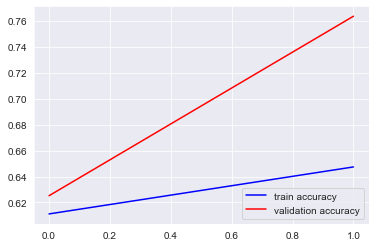

{'loss': [1.075122356414795, 1.0386415719985962], 'accuracy': [0.6112009882926941, 0.6473918557167053], 'val_loss': [1.1230084896087646, 0.8157471418380737], 'val_accuracy': [0.6252273917198181, 0.763493001461029]}


In [31]:
print(history_embedding.history)

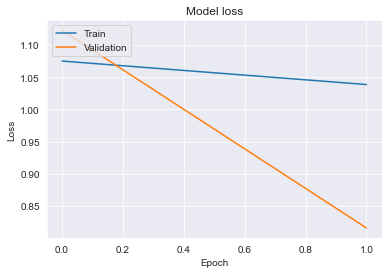

In [32]:
contacts_utils.plot_loss(history_embedding)

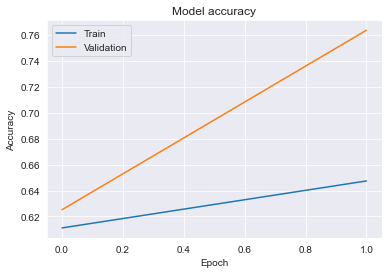

In [33]:
contacts_utils.plot_accuracy(history_embedding)

In [34]:
# use a PCA decomposition to visualize the embeddings in 2D
def pca_scatterplot(model, words):
    pca = PCA(n_components=2, random_state=92)
    word_vectors = np.array([model[w] for w in words])
    low_dim_emb = pca.fit_transform(word_vectors)
    plt.figure(figsize=(21,10))
    plt.scatter(low_dim_emb[:,0], low_dim_emb[:,1], edgecolors='blue', c='blue')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    # get the text of the plotted words
    texts = []
    for word, (x,y) in zip(words, low_dim_emb):
        texts.append(plt.text(x+0.01, y+0.01, word, rotation=0))

    # adjust the position of the labels so that they dont overlap
    adjust_text(texts)
    # show plot
    plt.show()

['dryer', 'usual', 'service', 'great-service', 'shelf', 'awhile', 'disappointed']


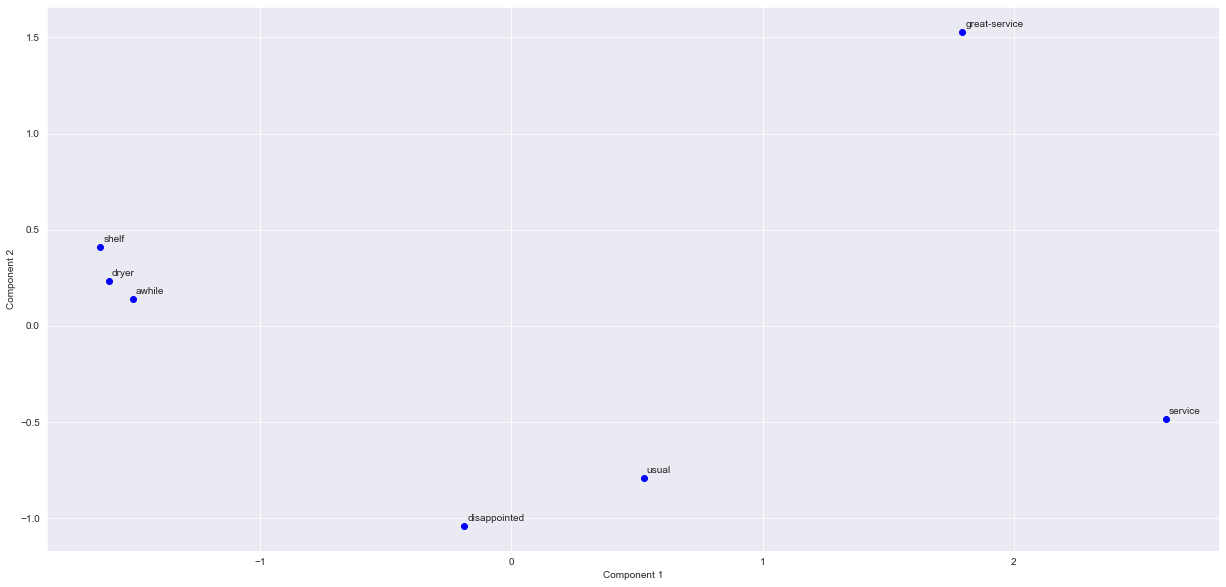

In [35]:
# define the tokens to use in the plot
tokens_of_interest = ['dryer', 'usual', 'service', 'great-service',  'shelf', 'awhile', 'disappointed']
print(tokens_of_interest)
# plot
pca_scatterplot(word_vectors, tokens_of_interest)